<a href="https://colab.research.google.com/github/Sat-A/s5-jax/blob/main/s5-Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S5-Predictor

The goal of this exercise is to adapt an annotated implementation of S5 https://github.com/JPGoodale/annotated-s5 that was made for classification tasks to regression tasks.

# Runtime Setup
Ensure runtime is set to GPU to ensure gpu parallelisation speedup

In [72]:
!pip install dm-haiku
!pip install hippox

In [73]:
# Let's go ahead and import hippox and the core JAX libraries we will be using:
import jax
import numpy as np
import jax.numpy as jnp
import haiku as hk
from hippox.main import Hippo
from typing import Optional
# New imports for stock data
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch  # Make sure torch is imported if not already
from torch.utils.data import DataLoader, Dataset as TorchDataset
from typing import NamedTuple
import matplotlib.pyplot as plt

First we'll define some helper functions for discretization and timescale initialization as the SSM equation is naturally continuous and must be made discrete to be unrolled as a linear recurrence like standard RNNs.

In [74]:
# Here we are just using the zero order hold method for its sheer simplicity, with A, B and delta_t denoting the
# state matrix, input matrix and change in timescale respectively.

def discretize(A, B, delta_t):
    Identity = jnp.ones(A.shape[0])
    _A = jnp.exp(A*delta_t)
    _B = (1/A * (_A-Identity)) * B
    return _A, _B

# This is a function used to initialize the trainable timescale parameter.
def log_step_initializer(dt_min=0.001, dt_max=0.1):
    def init(shape, dtype):
        uniform = hk.initializers.RandomUniform()
        return uniform(shape, dtype)*(jnp.log(dt_max) - jnp.log(dt_min)) + jnp.log(dt_min)
    return init

# Taken directly from https://github.com/deepmind/dm-haiku/blob/main/haiku/_src/recurrent.py
def add_batch(nest, batch_size: Optional[int]):
    broadcast = lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape)
    return jax.tree_util.tree_map(broadcast, nest)

The linear SSM equation is as follows:
$$ x_0(t) = Ax(t) + Bu(t) $$
$$ y(t) = Cx(t) + Du(t) $$

 We will now implement it as a recurrent Haiku module:

In [75]:
class LinearSSM(hk.RNNCore):
    def __init__(self, state_size: int, name: Optional[str] = None):
        super(LinearSSM, self).__init__(name=name)
        # We won't get into the basis measure families here, just note that they are basically just the
        # type of orthogonal polynomial we initialize with, the scaled Legendre measure (LegS) introduced
        # in the original HiPPO paper is pretty much the standard initialization and is what is used in the
        # main experiments in the S5 paper. I will also note that the Hippo class uses the diagonal representation
        # of the state matrix by default, as this has become the standard in neural SSMs since shown to be
        # equally effective as the diagonal plus low rank representation in https://arxiv.org/abs/2203.14343
        # and then formalized in https://arxiv.org/abs/2206.11893.

        _hippo = Hippo(state_size=state_size, basis_measure='legs')
        # Must be called for parameters to be initialized
        _hippo()

        # We register the real and imaginary components of the state matrix A as separate parameters because
        # they will have separate gradients in training, they will be conjoined back together and then discretized
        # but this will simply be backpropagated through as a transformation of the lambda real and imaginary
        # parameters (lambda is just what we call the diagonalized state matrix).

        self._lambda_real = hk.get_parameter(
            'lambda_real',
            shape=[state_size,],
            init=_hippo.lambda_initializer('real')
        )
        self._lambda_imag = hk.get_parameter(
            'lambda_imaginary',
            shape=[state_size,],
            init=_hippo.lambda_initializer('imaginary')
        )
        self._A = self._lambda_real + 1j * self._lambda_imag

       # For now, these initializations of the input and output matrices B and C match the S4D
        # parameterization for demonstration purposes, we will implement the S5 versions later.

        self._B = hk.get_parameter(
            'B',
            shape=[state_size,],
            init=_hippo.b_initializer()
        )
        self._C = hk.get_parameter(
            'C',
            shape=[state_size, 2],
            init=hk.initializers.RandomNormal(stddev=0.5**0.5)
        )
        self._output_matrix = self._C[..., 0] + 1j * self._C[..., 1]

        # This feed-through matrix basically acts as a residual connection.
        self._D = hk.get_parameter(
            'D',
            [1,],
            init=jnp.ones,
        )

        self._delta_t = hk.get_parameter(
            'delta_t',
            shape=[1,],
            init=log_step_initializer()
        )
        timescale = jnp.exp(self._delta_t)

        self._state_matrix, self._input_matrix = discretize(self._A, self._B, timescale)

    def __call__(self, inputs, prev_state):
        u = inputs[:, jnp.newaxis]
        new_state = self._state_matrix @ prev_state + self._input_matrix @ u
        y_s = self._output_matrix @ new_state
        out = y_s.reshape(-1).real + self._D * u
        return out, new_state

    def initial_state(self, batch_size: Optional[int] = None):
        state = jnp.zeros([self._state_size])
        if batch_size is not None:
            state = add_batch(state, batch_size)
        return state

You may notice that this looks an awful lot like a vanilla RNN cell, just with our special parameterization and without any activations, hence being a linear recurrence. I have initialized it as an instance of Haiku's RNN.Core abstract base class so that it can be unrolled using either the hk.dynamic_unroll or hk.static_unroll functions like any other recurrent module, however, if you are familiar with any of the S4 models you may be noticing that there's something crucial missing here: the convolutional representation. One of the key contributions of the S4 paper was its demonstration that the SSM ODE can be represented as either a linear recurrence, as above, for efficient inference, or as a global convolution for much faster training. That paper and the following papers then go on to present various kernels for efficiently computing this convolution with Fast Fourier Transforms, highly improving the computational efficiency of the model. Then why have we omitted them? Because the S5 architecture which we are about to explore simplifies all this by providing a purely recurrent representation in both training and inference, it does this by using a parallel recurrence that actually looks alot like a convolution itself! From the paper:

    "We use parallel scans to efficiently compute the states of a discretized linear SSM. Given a binary associative operator • (i.e. (a • b) • c = a • (b • c)) and a sequence of L elements [a1, a2, ..., aL], the scan operation (sometimes referred to as all-prefix-sum) returns the sequence [a1, (a1 • a2), ..., (a1 • a2 • ... • aL)]."

Let's see what this looks like in code, taken straight from the original author's implementation:

In [76]:
@jax.vmap
def binary_operator(q_i, q_j):
    A_i, b_i = q_i
    A_j, b_j = q_j
    return A_j * A_i, A_j * b_i + b_j

def parallel_scan(A, B, C, inputs):
    A_elements = A * jnp.ones((inputs.shape[0], A.shape[0]))
    Bu_elements = jax.vmap(lambda u: B @ u)(inputs)
    # Jax's built-in associative scan really comes in handy here as it executes a similar scan
    # operation as used in a normal recurrent unroll but is specifically tailored to fit an associative
    # operation like the one described in the paper.
    _, xs = jax.lax.associative_scan(binary_operator, (A_elements, Bu_elements))
    return jax.vmap(lambda x: (C @ x).real)(xs)

It's that simple! In the original S4 we would have had to apply an independent singe-input, single-output (SISO) SSM for each feature of the input sequence such as in this excerpt from Sasha Rush's Flax implementation:



```python
def cloneLayer(layer):
    return flax.linen.vmap(
        layer,
        in_axes=1,
        out_axes=1,
        variable_axes={"params": 1, "cache": 1, "prime": 1},
        split_rngs={"params": True},
    )
SSMLayer = cloneLayer(SSMLayer)```



Whereas in the S5 we process the entire sequence in one multi-input, multi-output (MIMO) layer.

Let's now rewrite our Module as a full S5 layer using this new method, we will be adding a few extra conditional arguments as well as changing some parameterization to match the original paper, but we'll walk through the reason for all these changes below.

In [77]:
# First we add a new helper function for the timescale initialization, this one just takes the previous
# log_step_initializer and stores a bunch of them in an array since our model is now multi-in, multi-out.

def init_log_steps(shape, dtype):
    H = shape[0]
    log_steps = []
    for i in range(H):
        log_step = log_step_initializer()(shape=(1,), dtype=dtype)
        log_steps.append(log_step)

    return jnp.array(log_steps)

In [78]:
# We will also rewrite our discretization for the MIMO context
def discretize(A, B, delta_t):
    Identity = jnp.ones(A.shape[0])
    _A = jnp.exp(A*delta_t)
    _B = (1/A * (_A-Identity))[..., None] * B
    return _A, _B

In [79]:
class S5(hk.Module):
    def __init__(self,
                 state_size: int,

                 # Now that we're MIMO we'll need to know the number of input features, commonly
                 # referred to as the dimension of the model.
                 d_model: int,

                 # We must also now specify the number of blocks that we will split our matrices
                 # into due to the MIMO context.
                 n_blocks: int,

                 # Short for conjugate symmetry, because our state matrix is complex we can half
                 # the size of it since complex numbers are a real and imaginary number joined together,
                 # this is not new to the S5, we just didn't mention it above.
                 conj_sym: bool = True,

                 # Another standard SSM argument that we omitted above for simplicity's sake,
                 # this forces the real part of the state matrix to be negative for better
                 # stability, especially in autoregressive tasks.
                 clip_eigns: bool = False,

                 # Like most RNNs, the S5 can be run in both directions if need be.
                 bidirectional: bool = False,

                 # Rescales delta_t for varying input resolutions, such as different audio
                 # sampling rates.
                 step_rescale: float = 1.0,
                 name: Optional[str] = None
    ):
        super(S5, self).__init__(name=name)
        self.conj_sym = conj_sym
        self.bidirectional = bidirectional

        # Note that the Hippo class takes conj_sym as an argument and will automatically half
        # the state size provided in its initialization, which is why we need to provide a local
        # state size that matches this for the shape argument in hk.get_parameter().

        if conj_sym:
            _state_size = state_size // 2
        else:
            _state_size = state_size

        # With block_diagonal set as True and the number of blocks provided, our Hippo class
        # will automatically handle this change of structure.

        _hippo = Hippo(
            state_size=state_size,
            basis_measure='legs',
            conj_sym=conj_sym,
            block_diagonal=True,
            n_blocks=n_blocks,
        )
        _hippo()

        self._lambda_real = hk.get_parameter(
            'lambda_real',
            [_state_size],
            init=_hippo.lambda_initializer('real')
        )
        self._lambda_imag = hk.get_parameter(
            'lambda_imaginary',
            [_state_size],
            init=_hippo.lambda_initializer('imaginary')
        )
        if clip_eigns:
            self._lambda = jnp.clip(self._lambda_real, None, -1e-4) + 1j * self._lambda_imag
        else:
            self._A = self._lambda_real + 1j * self._lambda_imag

        # If you recall, I mentioned above that we are automatically using a diagonalized version of
        # the HiPPO state matrix rather than the pure one, due to it being very hard to efficiently
        # compute. I will now go into a little more detail on how this diagonal representation is
        # derived, as it is important for how we initialize the input and output matrices. The diagonal
        # decomposition of our state matrix is based on equivalence relation on the SSM parameters:
        # (A, B, C) ∼ (V−1AV ,V−1B, CV) with V being the eigenvector of our original A matrix and V-1
        # being the inverse eigenvector. The Hippo class has already performed the decomposition of A
        # into (V-1AV) automatically, but we have not yet performed the decomposition of B and C, we will
        # use the eigenvector_transform class method for that below, but first we must initialize B and C
        # as normal distributions, lecun normal and truncated normal respectively. I will note that there
        # are a few other options provided for C in the original repository but, to keep it simple, we will
        # just use one here.

        b_init = hk.initializers.VarianceScaling()
        b_shape = [state_size, d_model]
        b_init = b_init(b_shape, dtype=jnp.complex64)
        self._B = hk.get_parameter(
            'B',
            [_state_size, d_model, 2],
            init=_hippo.eigenvector_transform(b_init,  concatenate=True),
        )
        B = self._B[..., 0] + 1j * self._B[..., 1]

        c_init = hk.initializers.TruncatedNormal()
        c_shape = [d_model, state_size, 2]
        c_init = c_init(c_shape, dtype=jnp.complex64)
        self._C = hk.get_parameter(
            'C',
            [d_model, _state_size, 2],
            init=_hippo.eigenvector_transform(c_init, inverse=False, concatenate=True),
        )
        # We need two output heads if bidirectional is True.
        if bidirectional:
            self._C2 = hk.get_parameter(
                'C2',
                [d_model, _state_size, 2],
                init=_hippo.eigenvector_transform(c_init, inverse=False, concatenate=True),
            )
            C1 = self._C[..., 0] + 1j * self._C[..., 1]
            C2 = self._C2[..., 0] + 1j * self._C2[..., 1]
            self._output_matrix = jnp.concatenate((C1, C2), axis=-1)
        else:
            self._output_matrix = self._C[..., 0] + 1j * self._C[..., 1]

        self._D = hk.get_parameter(
            'D',
            [d_model,],
            init=hk.initializers.RandomNormal(stddev=1.0)
        )

        self._delta_t = hk.get_parameter(
            'delta_T',
            [_state_size, 1],
            init=init_log_steps
        )
        timescale = step_rescale * jnp.exp(self._delta_t[:, 0])

        # We could also use the bilinear discretization method, but we'll just stick to zoh for now.
        self._state_matrix, self._input_matrix = discretize(self._A, B, timescale)


    def __call__(self, inputs):
        # Note that this is the exact same function as presented above just with alternate procedures
        # depending on the bidirectional and conjugate symmetry arguments

        A_elements = self._state_matrix * jnp.ones((inputs.shape[0], self._state_matrix.shape[0]))
        Bu_elements = jax.vmap(lambda u: self._input_matrix @ u)(inputs)

        _, xs = jax.lax.associative_scan(binary_operator, (A_elements, Bu_elements))

        if self.bidirectional:
            _, xs2 = jax.lax.associative_scan(binary_operator,
                                          (A_elements, Bu_elements),
                                          reverse=True)
            xs = jnp.concatenate((xs, xs2), axis=-1)

        if self.conj_sym:
            ys = jax.vmap(lambda x: 2*(self._output_matrix @ x).real)(xs)
        else:
            ys = jax.vmap(lambda x: (self._output_matrix @ x).real)(xs)

        Du = jax.vmap(lambda u: self._D * u)(inputs)

        return ys + Du

There we have it, a complete S5 layer! Now let's form a block around it using a structure very similar to a transformer block with a Gated Linear Unit (GLU).

In [80]:
import dataclasses

@dataclasses.dataclass
class S5Block(hk.Module):
    ssm: S5
    d_model: int
    dropout_rate: float
    prenorm: bool
    istraining: bool = True
    name: Optional[str] = None

    def __post_init__(self):
        super(S5Block, self).__post_init__()
        # We could use either layer norm or batch norm.
        self._norm = hk.LayerNorm(axis=-1, create_scale=True, create_offset=True)
        self._linear = hk.Linear(self.d_model)

    def __call__(self, x):
        skip = x
        if self.prenorm:
            x = self._norm(x)

        x = self.ssm(x)
        # There are a couple of other GLU patterns we could use here, but once again I have chosen
        # one semi-arbitrarily to avoid cluttering our module with if statements.
        x1 = hk.dropout(hk.next_rng_key(), self.dropout_rate, jax.nn.gelu(x))
        x = x * jax.nn.sigmoid(self._linear(x1))
        x = hk.dropout(hk.next_rng_key(), self.dropout_rate, x)

        x = skip + x
        if not self.prenorm:
            x = self._norm(x)

        return x

Now let's make a stack of these blocks:

In [81]:
@dataclasses.dataclass
class S5Stack(hk.Module):
    ssm: S5
    d_model: int
    n_layers: int
    dropout_rate: float
    prenorm: bool
    istraining: bool = True
    name: Optional[str] = None

    def __post_init__(self):
        super(S5Stack, self).__post_init__(name=self.name)
        self._encoder = hk.Linear(self.d_model)
        self._layers = [
            S5Block(
                ssm=self.ssm,
                d_model=self.d_model,
                dropout_rate=self.dropout_rate,
                istraining=self.istraining,
                prenorm=self.prenorm,
            )
            for _ in range(self.n_layers)
        ]

    def __call__(self, x):
        x = self._encoder(x)
        for layer in self._layers:
            x = layer(x)
        return x

# Implementing Regression in S5

Create a new dataset class to hold our stock data

In [82]:
# --- New Data Section ---

# This custom Dataset class will hold our sliding windows
class StockWindowDataset(TorchDataset):
    def __init__(self, data, labels):
        # Explicitly convert JAX array -> NumPy array -> Torch tensor
        self.data = torch.tensor(np.array(data), dtype=torch.float32)
        self.labels = torch.tensor(np.array(labels), dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # We need to add an extra dimension for the input feature
        return self.data[idx][..., None], self.labels[idx]

def create_stock_dataset(batch_size=64, in_seq_length=7, out_seq_length=7):
    print("[*] Generating Stock Price Dataset...")

    # 1. Download data
    # Let's use the S&P 500 index as an example
    ticker = "^GSPC"
    data = yf.download(ticker, start="2000-01-01", end="2023-12-31")

    # We'll use 'Close' as the representative "average" price
    prices = data[['Close']].values

    # 2. Normalise the data
    # We fit the scaler ONLY on the training data to prevent data leakage
    train_split_idx = int(len(prices) * 0.8)
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Fit on training data
    scaler.fit(prices[:train_split_idx])

    # Transform all data
    prices_scaled = scaler.transform(prices).flatten() # Flatten to 1D array

    # 3. Create sliding windows
    X, y = [], []
    # We need to stop in_seq_length + out_seq_length from the end
    for i in range(len(prices_scaled) - in_seq_length - out_seq_length + 1):
        X.append(prices_scaled[i : i + in_seq_length])
        y.append(prices_scaled[i + in_seq_length : i + in_seq_length + out_seq_length]) # Get next 7 days

    X = jnp.array(X)
    y = jnp.array(y) # y is now a 2D array [num_samples, 7]

    # 4. Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False # Time-series data should not be shuffled
    )

    print(f"[*] Train samples: {len(X_train)}, Test samples: {len(X_test)}")

    # 5. Create DataLoaders
    train_dataset = StockWindowDataset(X_train, y_train)
    test_dataset = StockWindowDataset(X_test, y_test)

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # N_CLASSES is now 1 (we predict one value)
    # SEQ_LENGTH is our window size (7)
    # IN_DIM is 1 (just the price)
    OUT_DIM = out_seq_length # This will be 7
    IN_DIM = 1

    # We also return the scaler so we can invert the predictions later
    return trainloader, testloader, OUT_DIM, in_seq_length, IN_DIM, scaler

# Replace the Datasets dict and create_dataset function
Datasets = {
    "stock-prediction": create_stock_dataset,
}

# Simple class for storing our dataset parameters
class Dataset(NamedTuple):
    trainloader: DataLoader
    testloader: DataLoader
    n_classes: int  # This will be 1
    in_seq_length: int # This will be 7
    out_seq_length: int # This will also be 7
    d_input: int    # This will be 1
    scaler: MinMaxScaler # Store the scaler
    classification: bool

def create_dataset(dataset: str, batch_size: int, in_seq_length: int, out_seq_length: int) -> Dataset:
    classification = 'classification' in dataset
    dataset_init = Datasets[dataset]

    # Pass seq_length to the function
    # Note: the `in_seq_length` returned here is the same one we passed in
    trainloader, testloader, OUT_DIM, _, IN_DIM, scaler = dataset_init(
        batch_size=batch_size, in_seq_length=in_seq_length, out_seq_length = out_seq_length
    )

    return Dataset(
        trainloader,         # 1. trainloader
        testloader,          # 2. testloader
        OUT_DIM,             # 3. n_classes
        in_seq_length,       # 4. in_seq_length
        out_seq_length,      # 5. out_seq_length (This was missing)
        IN_DIM,              # 6. d_input
        scaler,              # 7. scaler
        classification       # 8. classification
    )

# Creating our Regressor

In [83]:
from re import X
# Replace S5Classifier with S5Regressor

@dataclasses.dataclass
class S5Regressor(hk.Module):
    ssm: S5
    d_model: int
    d_output: int  # This will be 1 for our task
    n_layers: int
    dropout_rate: float
    mode: str = 'last'  # 'last' is more common for time-series prediction
    prenorm: bool = True
    istraining: bool = True
    name: Optional[str] = None

    def __post_init__(self):
        super(S5Regressor, self).__post_init__(name=self.name)
        self._encoder = S5Stack(
            ssm=self.ssm,
            d_model=self.d_model,
            n_layers=self.n_layers,
            dropout_rate=self.dropout_rate,
            istraining=self.istraining,
            prenorm=self.prenorm,
        )
        self._decoder = hk.Linear(self.d_output)

    def __call__(self, x):
        x = self._encoder(x)

        # For predicting the next step, using the 'last' hidden state
        # is usually the best approach.
        if self.mode == 'pool':
            x = jnp.mean(x, axis=0)
        elif self.mode == 'last':
            x = x[-1] # Take the last element of the sequence
        else:
            raise NotImplementedError("Mode must be in ['pool', 'last]")

        x = self._decoder(x)

        # CRITICAL: Remove the log_softmax! We want the raw output value.
        # We also squeeze the last dimension to match the label shape (batch_size,)
        return x

Next we will set some hyperparameters:

In [84]:
# --- Set Hyperparameters ---
# These are a good start, but you will need to tune them for this new task.
STATE_SIZE: int = 64   # Reduced for a simpler 1D input
D_MODEL: int = 32    # Reduced
N_LAYERS: int = 4
N_BLOCKS: int = 4
EPOCHS: int = 50
BATCH_SIZE: int = 64
DROPOUT_RATE: float = 0.1
LEARNING_RATE: float = 1e-3
SEED = 0
IN_SEQ_LENGTH: int = 252  # One trading year of history
OUT_SEQ_LENGTH: int = 7

To keep things simple for this example, we will just be using a plain adam optimizer, but the results can be highly improved with extra techniques such as cosine annealing, learning rate schedules and weight decay.

In [85]:
import optax

class TrainingState(NamedTuple):
    params: hk.Params
    opt_state: optax.OptState
    rng_key: jnp.ndarray

optim = optax.adam(LEARNING_RATE)


Now for the loss and update functions:

In [86]:
from functools import partial
from typing import Tuple, MutableMapping, Any
_Metrics = MutableMapping[str, Any]

# Replace cross_entropy_loss and compute_accuracy

@partial(jnp.vectorize, signature="(),()->()")
def mse_loss(prediction, target) -> jnp.ndarray:
    """Computes Mean Squared Error loss."""
    return (prediction - target) ** 2

# We no longer need compute_accuracy

# --- Modify the 'update' function ---
@partial(jax.jit, static_argnums=(3, 4))
def update(
        state: TrainingState,
        inputs: jnp.ndarray,
        targets: jnp.ndarray,
        model: hk.transform,
        classification: bool,) -> Tuple[TrainingState, _Metrics]:

    rng_key, next_rng_key = jax.random.split(state.rng_key)

    def loss_fn(params):
        # 'predictions' instead of 'logits'
        predictions = model.apply(params, rng_key, inputs)

        # Use MSE loss
        _loss = jnp.mean(mse_loss(predictions, targets))

        # We return loss as the primary value and as an aux value
        return _loss, _loss

    # This 'if' is no longer needed, but harmless if left.
    # if not classification:
    #     targets = inputs[:, :, 0]

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

    # (loss, loss_metric), gradients
    (loss, _), gradients = grad_fn(state.params)

    updates, new_opt_state = optim.update(gradients, state.opt_state, state.params)
    new_params = optax.apply_updates(state.params, updates)

    new_state = TrainingState(
        params=new_params,
        opt_state=new_opt_state,
        rng_key=next_rng_key,
    )
    metrics = {
        'loss': loss, # We only track loss now
    }

    return new_state, metrics

# --- Modify the 'evaluate' function ---
@partial(jax.jit, static_argnums=(3, 4))
def evaluate(
        state: TrainingState,
        inputs: jnp.ndarray,
        targets: jnp.ndarray,
        model: hk.transform,
        classification,) -> _Metrics:

    rng_key, _ = jax.random.split(state.rng_key, 2)

    # if not classification:
    #     targets = inputs[:, :, 0]

    predictions = model.apply(state.params, rng_key, inputs)
    loss = jnp.mean(mse_loss(predictions, targets))

    metrics = {
        'loss': loss, # We only track loss
    }

    return metrics


Now we call these update and evaluate functions in their respective epochs:

In [87]:
from tqdm import tqdm

# --- Modify 'training_epoch' ---
def training_epoch(
        state: TrainingState,
        trainloader: DataLoader,
        model: hk.transform,
        classification: bool = False,) -> Tuple[TrainingState, jnp.ndarray]: # Removed accuracy output

    batch_losses = [] # Removed batch_accuracies
    for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader)):
        inputs = jnp.array(inputs.numpy())
        targets = jnp.array(targets.numpy())
        state, metrics = update(
            state, inputs, targets,
            model, classification
        )
        batch_losses.append(metrics['loss'])
        # Removed accuracy

    return (
        state,
        jnp.mean(jnp.array(batch_losses)),
        # Removed accuracy
    )

# --- Modify 'validation_epoch' ---
def validation_epoch(
    state: TrainingState,
    testloader: DataLoader,
    model: hk.transform,
    classification: bool = True,) -> jnp.ndarray: # Removed accuracy output

    losses = [] # Removed accuracies
    for batch_idx, (inputs, targets) in enumerate(tqdm(testloader)):
        inputs = jnp.array(inputs.numpy())
        targets = jnp.array(targets.numpy())
        metrics = evaluate(
            state, inputs, targets,
            model, classification
        )
        losses.append(metrics['loss'])
        # Removed accuracy

    return jnp.mean(jnp.array(losses)) # Removed accuracy

In [88]:
import torch
# Set random number generators
torch.random.manual_seed(SEED)
key = jax.random.PRNGKey(SEED)
rng, init_rng = jax.random.split(key)

In [89]:
# Note: We now pass IN_SEQ_LENGTH AND OUT_SEQ_LENGTH
ds = create_dataset(
    'stock-prediction',
    batch_size = BATCH_SIZE,
    in_seq_length = IN_SEQ_LENGTH,
    out_seq_length = OUT_SEQ_LENGTH
)
init_data = jnp.array(next(iter(ds.trainloader))[0].numpy())

/tmp/ipython-input-1979305063.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2000-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed

[*] Generating Stock Price Dataset...


[*] Train samples: 4623, Test samples: 1156


In [90]:
# In Haiku, we have to call our model inside a transformed function using hk.transform for it to become
# functionally pure and compatible with essential JAX functions like jax.grad(). Here we are using hk.vmap
# instead of jax.vmap because we are calling it from within a hk.transform.
@hk.transform
def forward(x) -> hk.transform:
    # Use S5Regressor
    neural_net = S5Regressor(
        S5(
            STATE_SIZE,
            D_MODEL,
            N_BLOCKS,
        ),
        D_MODEL,
        ds.n_classes,  # This will be 1
        N_LAYERS,
        DROPOUT_RATE,
    )
    return hk.vmap(neural_net, split_rng=False)(x)

In [91]:
# Set state
initial_params = forward.init(init_rng, init_data)
initial_opt_state = optim.init(initial_params)

state = TrainingState(
    params=initial_params,
    opt_state=initial_opt_state,
    rng_key=rng)

/usr/local/lib/python3.12/dist-packages/jax/_src/lax/lax.py:1660: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)  # type: ignore[unused-ignore,bad-return-type]


# Training and Plotting

In [92]:
# --- Lists to store loss history ---
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    print(f"[*] Training Epoch {epoch + 1}...")
    state, training_loss = training_epoch(
        state,
        ds.trainloader,
        forward,
        ds.classification
    )
    print(f"[*] Running Epoch {epoch + 1} Validation...")
    test_loss = validation_epoch(
        state,
        ds.testloader,
        forward,
        ds.classification
    )

    # --- Store the losses ---
    train_losses.append(training_loss)
    test_losses.append(test_loss)

    print(f"\n=>> Epoch {epoch + 1} Metrics ===")
    print(
        f"\tTrain Loss (MSE): {training_loss:.5f}\n\t Test Loss (MSE): {test_loss:.5f}"
    )

[*] Training Epoch 1...


  0%|          | 0/73 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/jax/_src/lax/lax.py:5473: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
100%|██████████| 73/73 [00:38<00:00,  1.91it/s]


[*] Running Epoch 1 Validation...


100%|██████████| 19/19 [00:11<00:00,  1.67it/s]



=>> Epoch 1 Metrics ===
	Train Loss (MSE): 14.46270
	 Test Loss (MSE): 35.78254
[*] Training Epoch 2...


100%|██████████| 73/73 [00:00<00:00, 161.88it/s]


[*] Running Epoch 2 Validation...


100%|██████████| 19/19 [00:00<00:00, 479.33it/s]



=>> Epoch 2 Metrics ===
	Train Loss (MSE): 5.97752
	 Test Loss (MSE): 4.13703
[*] Training Epoch 3...


100%|██████████| 73/73 [00:00<00:00, 231.95it/s]


[*] Running Epoch 3 Validation...


100%|██████████| 19/19 [00:00<00:00, 498.60it/s]



=>> Epoch 3 Metrics ===
	Train Loss (MSE): 2.93753
	 Test Loss (MSE): 0.99896
[*] Training Epoch 4...


100%|██████████| 73/73 [00:00<00:00, 234.17it/s]


[*] Running Epoch 4 Validation...


100%|██████████| 19/19 [00:00<00:00, 557.03it/s]



=>> Epoch 4 Metrics ===
	Train Loss (MSE): 1.94246
	 Test Loss (MSE): 2.04289
[*] Training Epoch 5...


100%|██████████| 73/73 [00:00<00:00, 232.67it/s]


[*] Running Epoch 5 Validation...


100%|██████████| 19/19 [00:00<00:00, 464.03it/s]



=>> Epoch 5 Metrics ===
	Train Loss (MSE): 1.52279
	 Test Loss (MSE): 1.47764
[*] Training Epoch 6...


100%|██████████| 73/73 [00:00<00:00, 231.98it/s]


[*] Running Epoch 6 Validation...


100%|██████████| 19/19 [00:00<00:00, 555.25it/s]



=>> Epoch 6 Metrics ===
	Train Loss (MSE): 1.14661
	 Test Loss (MSE): 1.03281
[*] Training Epoch 7...


100%|██████████| 73/73 [00:00<00:00, 233.02it/s]


[*] Running Epoch 7 Validation...


100%|██████████| 19/19 [00:00<00:00, 512.17it/s]



=>> Epoch 7 Metrics ===
	Train Loss (MSE): 0.94909
	 Test Loss (MSE): 4.79770
[*] Training Epoch 8...


100%|██████████| 73/73 [00:00<00:00, 233.24it/s]


[*] Running Epoch 8 Validation...


100%|██████████| 19/19 [00:00<00:00, 528.87it/s]



=>> Epoch 8 Metrics ===
	Train Loss (MSE): 0.77412
	 Test Loss (MSE): 0.35958
[*] Training Epoch 9...


100%|██████████| 73/73 [00:00<00:00, 232.39it/s]


[*] Running Epoch 9 Validation...


100%|██████████| 19/19 [00:00<00:00, 403.03it/s]



=>> Epoch 9 Metrics ===
	Train Loss (MSE): 0.60415
	 Test Loss (MSE): 3.04846
[*] Training Epoch 10...


100%|██████████| 73/73 [00:00<00:00, 231.35it/s]


[*] Running Epoch 10 Validation...


100%|██████████| 19/19 [00:00<00:00, 542.18it/s]



=>> Epoch 10 Metrics ===
	Train Loss (MSE): 0.52566
	 Test Loss (MSE): 1.28336
[*] Training Epoch 11...


100%|██████████| 73/73 [00:00<00:00, 231.88it/s]


[*] Running Epoch 11 Validation...


100%|██████████| 19/19 [00:00<00:00, 522.59it/s]



=>> Epoch 11 Metrics ===
	Train Loss (MSE): 0.42431
	 Test Loss (MSE): 0.89174
[*] Training Epoch 12...


100%|██████████| 73/73 [00:00<00:00, 232.39it/s]


[*] Running Epoch 12 Validation...


100%|██████████| 19/19 [00:00<00:00, 538.50it/s]



=>> Epoch 12 Metrics ===
	Train Loss (MSE): 0.32776
	 Test Loss (MSE): 0.79151
[*] Training Epoch 13...


100%|██████████| 73/73 [00:00<00:00, 230.55it/s]


[*] Running Epoch 13 Validation...


100%|██████████| 19/19 [00:00<00:00, 545.51it/s]



=>> Epoch 13 Metrics ===
	Train Loss (MSE): 0.32075
	 Test Loss (MSE): 0.70061
[*] Training Epoch 14...


100%|██████████| 73/73 [00:00<00:00, 231.79it/s]


[*] Running Epoch 14 Validation...


100%|██████████| 19/19 [00:00<00:00, 549.26it/s]



=>> Epoch 14 Metrics ===
	Train Loss (MSE): 0.26849
	 Test Loss (MSE): 1.02496
[*] Training Epoch 15...


100%|██████████| 73/73 [00:00<00:00, 232.42it/s]


[*] Running Epoch 15 Validation...


100%|██████████| 19/19 [00:00<00:00, 480.83it/s]



=>> Epoch 15 Metrics ===
	Train Loss (MSE): 0.27014
	 Test Loss (MSE): 0.40640
[*] Training Epoch 16...


100%|██████████| 73/73 [00:00<00:00, 231.68it/s]


[*] Running Epoch 16 Validation...


100%|██████████| 19/19 [00:00<00:00, 512.29it/s]



=>> Epoch 16 Metrics ===
	Train Loss (MSE): 0.20879
	 Test Loss (MSE): 0.47740
[*] Training Epoch 17...


100%|██████████| 73/73 [00:00<00:00, 230.43it/s]


[*] Running Epoch 17 Validation...


100%|██████████| 19/19 [00:00<00:00, 468.68it/s]



=>> Epoch 17 Metrics ===
	Train Loss (MSE): 0.19467
	 Test Loss (MSE): 0.68394
[*] Training Epoch 18...


100%|██████████| 73/73 [00:00<00:00, 229.79it/s]


[*] Running Epoch 18 Validation...


100%|██████████| 19/19 [00:00<00:00, 542.86it/s]



=>> Epoch 18 Metrics ===
	Train Loss (MSE): 0.17892
	 Test Loss (MSE): 0.19296
[*] Training Epoch 19...


100%|██████████| 73/73 [00:00<00:00, 231.57it/s]


[*] Running Epoch 19 Validation...


100%|██████████| 19/19 [00:00<00:00, 517.57it/s]



=>> Epoch 19 Metrics ===
	Train Loss (MSE): 0.17431
	 Test Loss (MSE): 2.91326
[*] Training Epoch 20...


100%|██████████| 73/73 [00:00<00:00, 231.98it/s]


[*] Running Epoch 20 Validation...


100%|██████████| 19/19 [00:00<00:00, 528.97it/s]



=>> Epoch 20 Metrics ===
	Train Loss (MSE): 0.16120
	 Test Loss (MSE): 0.67485
[*] Training Epoch 21...


100%|██████████| 73/73 [00:00<00:00, 231.49it/s]


[*] Running Epoch 21 Validation...


100%|██████████| 19/19 [00:00<00:00, 511.38it/s]



=>> Epoch 21 Metrics ===
	Train Loss (MSE): 0.11606
	 Test Loss (MSE): 0.59117
[*] Training Epoch 22...


100%|██████████| 73/73 [00:00<00:00, 229.72it/s]


[*] Running Epoch 22 Validation...


100%|██████████| 19/19 [00:00<00:00, 546.17it/s]



=>> Epoch 22 Metrics ===
	Train Loss (MSE): 0.09899
	 Test Loss (MSE): 0.28628
[*] Training Epoch 23...


100%|██████████| 73/73 [00:00<00:00, 230.36it/s]


[*] Running Epoch 23 Validation...


100%|██████████| 19/19 [00:00<00:00, 525.46it/s]



=>> Epoch 23 Metrics ===
	Train Loss (MSE): 0.09926
	 Test Loss (MSE): 0.44105
[*] Training Epoch 24...


100%|██████████| 73/73 [00:00<00:00, 230.85it/s]


[*] Running Epoch 24 Validation...


100%|██████████| 19/19 [00:00<00:00, 557.98it/s]



=>> Epoch 24 Metrics ===
	Train Loss (MSE): 0.11616
	 Test Loss (MSE): 0.32119
[*] Training Epoch 25...


100%|██████████| 73/73 [00:00<00:00, 231.53it/s]


[*] Running Epoch 25 Validation...


100%|██████████| 19/19 [00:00<00:00, 517.58it/s]



=>> Epoch 25 Metrics ===
	Train Loss (MSE): 0.09209
	 Test Loss (MSE): 0.37785
[*] Training Epoch 26...


100%|██████████| 73/73 [00:00<00:00, 228.99it/s]


[*] Running Epoch 26 Validation...


100%|██████████| 19/19 [00:00<00:00, 305.30it/s]



=>> Epoch 26 Metrics ===
	Train Loss (MSE): 0.08702
	 Test Loss (MSE): 0.41867
[*] Training Epoch 27...


100%|██████████| 73/73 [00:00<00:00, 225.84it/s]


[*] Running Epoch 27 Validation...


100%|██████████| 19/19 [00:00<00:00, 356.06it/s]



=>> Epoch 27 Metrics ===
	Train Loss (MSE): 0.07834
	 Test Loss (MSE): 0.32664
[*] Training Epoch 28...


100%|██████████| 73/73 [00:00<00:00, 227.36it/s]


[*] Running Epoch 28 Validation...


100%|██████████| 19/19 [00:00<00:00, 322.13it/s]



=>> Epoch 28 Metrics ===
	Train Loss (MSE): 0.08105
	 Test Loss (MSE): 0.40608
[*] Training Epoch 29...


100%|██████████| 73/73 [00:00<00:00, 205.25it/s]


[*] Running Epoch 29 Validation...


100%|██████████| 19/19 [00:00<00:00, 289.20it/s]



=>> Epoch 29 Metrics ===
	Train Loss (MSE): 0.07715
	 Test Loss (MSE): 0.34643
[*] Training Epoch 30...


100%|██████████| 73/73 [00:00<00:00, 209.74it/s]


[*] Running Epoch 30 Validation...


100%|██████████| 19/19 [00:00<00:00, 479.87it/s]



=>> Epoch 30 Metrics ===
	Train Loss (MSE): 0.06653
	 Test Loss (MSE): 0.14471
[*] Training Epoch 31...


100%|██████████| 73/73 [00:00<00:00, 229.10it/s]


[*] Running Epoch 31 Validation...


100%|██████████| 19/19 [00:00<00:00, 556.61it/s]



=>> Epoch 31 Metrics ===
	Train Loss (MSE): 0.06593
	 Test Loss (MSE): 0.28475
[*] Training Epoch 32...


100%|██████████| 73/73 [00:00<00:00, 229.62it/s]


[*] Running Epoch 32 Validation...


100%|██████████| 19/19 [00:00<00:00, 519.97it/s]



=>> Epoch 32 Metrics ===
	Train Loss (MSE): 0.05072
	 Test Loss (MSE): 0.44209
[*] Training Epoch 33...


100%|██████████| 73/73 [00:00<00:00, 227.81it/s]


[*] Running Epoch 33 Validation...


100%|██████████| 19/19 [00:00<00:00, 402.57it/s]



=>> Epoch 33 Metrics ===
	Train Loss (MSE): 0.05161
	 Test Loss (MSE): 0.12607
[*] Training Epoch 34...


100%|██████████| 73/73 [00:00<00:00, 230.24it/s]


[*] Running Epoch 34 Validation...


100%|██████████| 19/19 [00:00<00:00, 524.52it/s]



=>> Epoch 34 Metrics ===
	Train Loss (MSE): 0.05438
	 Test Loss (MSE): 0.15753
[*] Training Epoch 35...


100%|██████████| 73/73 [00:00<00:00, 229.77it/s]


[*] Running Epoch 35 Validation...


100%|██████████| 19/19 [00:00<00:00, 525.80it/s]



=>> Epoch 35 Metrics ===
	Train Loss (MSE): 0.05582
	 Test Loss (MSE): 0.13077
[*] Training Epoch 36...


100%|██████████| 73/73 [00:00<00:00, 230.30it/s]


[*] Running Epoch 36 Validation...


100%|██████████| 19/19 [00:00<00:00, 530.21it/s]



=>> Epoch 36 Metrics ===
	Train Loss (MSE): 0.05080
	 Test Loss (MSE): 0.15880
[*] Training Epoch 37...


100%|██████████| 73/73 [00:00<00:00, 229.70it/s]


[*] Running Epoch 37 Validation...


100%|██████████| 19/19 [00:00<00:00, 513.44it/s]



=>> Epoch 37 Metrics ===
	Train Loss (MSE): 0.05033
	 Test Loss (MSE): 0.21729
[*] Training Epoch 38...


100%|██████████| 73/73 [00:00<00:00, 228.72it/s]


[*] Running Epoch 38 Validation...


100%|██████████| 19/19 [00:00<00:00, 475.49it/s]



=>> Epoch 38 Metrics ===
	Train Loss (MSE): 0.04096
	 Test Loss (MSE): 0.08054
[*] Training Epoch 39...


100%|██████████| 73/73 [00:00<00:00, 229.09it/s]


[*] Running Epoch 39 Validation...


100%|██████████| 19/19 [00:00<00:00, 525.67it/s]



=>> Epoch 39 Metrics ===
	Train Loss (MSE): 0.03651
	 Test Loss (MSE): 0.08557
[*] Training Epoch 40...


100%|██████████| 73/73 [00:00<00:00, 230.41it/s]


[*] Running Epoch 40 Validation...


100%|██████████| 19/19 [00:00<00:00, 459.36it/s]



=>> Epoch 40 Metrics ===
	Train Loss (MSE): 0.03022
	 Test Loss (MSE): 0.09296
[*] Training Epoch 41...


100%|██████████| 73/73 [00:00<00:00, 227.70it/s]


[*] Running Epoch 41 Validation...


100%|██████████| 19/19 [00:00<00:00, 516.26it/s]



=>> Epoch 41 Metrics ===
	Train Loss (MSE): 0.03326
	 Test Loss (MSE): 0.42795
[*] Training Epoch 42...


100%|██████████| 73/73 [00:00<00:00, 229.57it/s]


[*] Running Epoch 42 Validation...


100%|██████████| 19/19 [00:00<00:00, 524.69it/s]



=>> Epoch 42 Metrics ===
	Train Loss (MSE): 0.03410
	 Test Loss (MSE): 0.07999
[*] Training Epoch 43...


100%|██████████| 73/73 [00:00<00:00, 229.45it/s]


[*] Running Epoch 43 Validation...


100%|██████████| 19/19 [00:00<00:00, 504.71it/s]



=>> Epoch 43 Metrics ===
	Train Loss (MSE): 0.02742
	 Test Loss (MSE): 0.07869
[*] Training Epoch 44...


100%|██████████| 73/73 [00:00<00:00, 229.47it/s]


[*] Running Epoch 44 Validation...


100%|██████████| 19/19 [00:00<00:00, 510.84it/s]



=>> Epoch 44 Metrics ===
	Train Loss (MSE): 0.03301
	 Test Loss (MSE): 0.21654
[*] Training Epoch 45...


100%|██████████| 73/73 [00:00<00:00, 229.26it/s]


[*] Running Epoch 45 Validation...


100%|██████████| 19/19 [00:00<00:00, 390.20it/s]



=>> Epoch 45 Metrics ===
	Train Loss (MSE): 0.02561
	 Test Loss (MSE): 0.06474
[*] Training Epoch 46...


100%|██████████| 73/73 [00:00<00:00, 227.27it/s]


[*] Running Epoch 46 Validation...


100%|██████████| 19/19 [00:00<00:00, 504.33it/s]



=>> Epoch 46 Metrics ===
	Train Loss (MSE): 0.02219
	 Test Loss (MSE): 0.09696
[*] Training Epoch 47...


100%|██████████| 73/73 [00:00<00:00, 229.19it/s]


[*] Running Epoch 47 Validation...


100%|██████████| 19/19 [00:00<00:00, 504.63it/s]



=>> Epoch 47 Metrics ===
	Train Loss (MSE): 0.02148
	 Test Loss (MSE): 0.06448
[*] Training Epoch 48...


100%|██████████| 73/73 [00:00<00:00, 229.58it/s]


[*] Running Epoch 48 Validation...


100%|██████████| 19/19 [00:00<00:00, 486.69it/s]



=>> Epoch 48 Metrics ===
	Train Loss (MSE): 0.01967
	 Test Loss (MSE): 0.08938
[*] Training Epoch 49...


100%|██████████| 73/73 [00:00<00:00, 229.13it/s]


[*] Running Epoch 49 Validation...


100%|██████████| 19/19 [00:00<00:00, 530.29it/s]



=>> Epoch 49 Metrics ===
	Train Loss (MSE): 0.02229
	 Test Loss (MSE): 0.04232
[*] Training Epoch 50...


100%|██████████| 73/73 [00:00<00:00, 228.85it/s]


[*] Running Epoch 50 Validation...


100%|██████████| 19/19 [00:00<00:00, 516.21it/s]


=>> Epoch 50 Metrics ===
	Train Loss (MSE): 0.01708
	 Test Loss (MSE): 0.04300



[*] Loss plot saved to loss_plot.png
[*] Prediction plot saved to prediction_plot.png


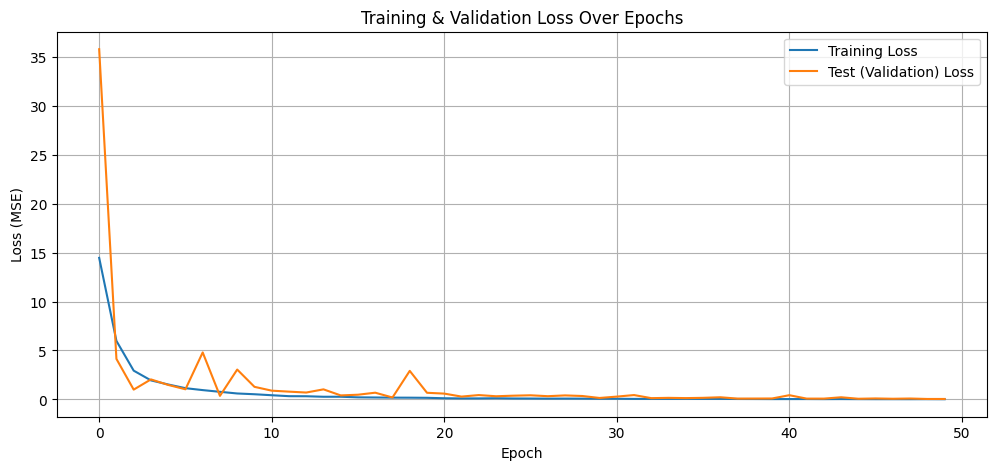

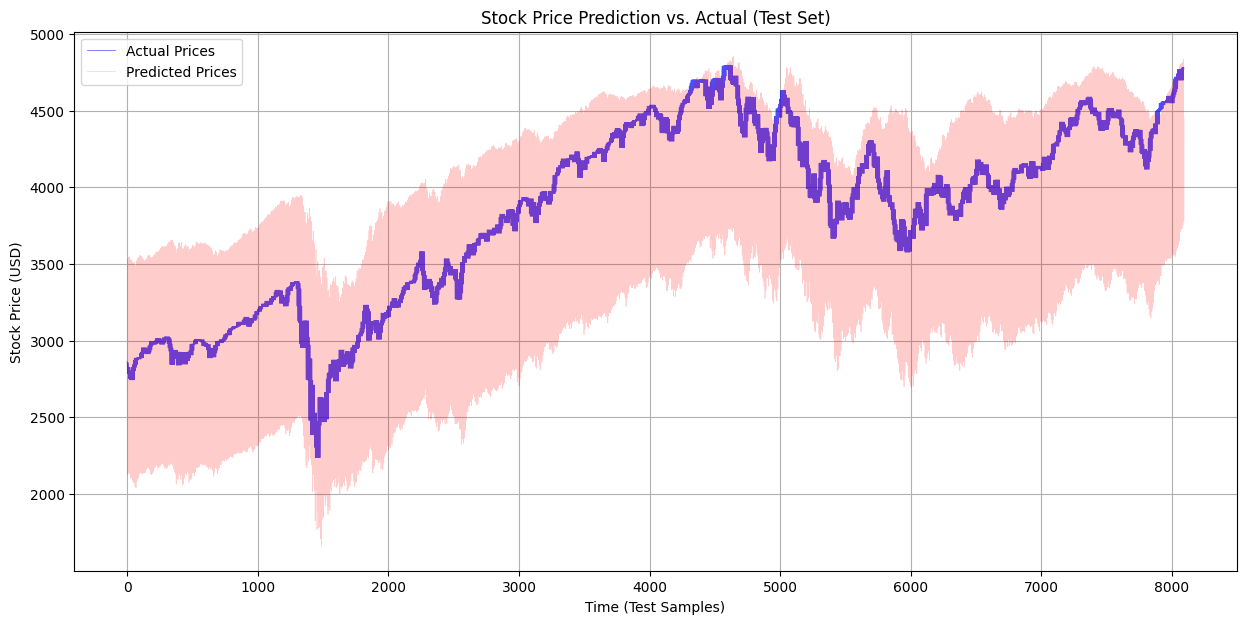

In [96]:
# --- Plot 1: Training & Validation Loss ---

plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test (Validation) Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')
print("\n[*] Loss plot saved to loss_plot.png")

# --- Plot 2: Actual vs. Predicted Prices ---

# 1. Get all predictions from the testloader
all_predictions = []
all_actuals = []

testloader_for_plotting = DataLoader(ds.testloader.dataset, batch_size=64, shuffle=False)
eval_rng = jax.random.PRNGKey(SEED + 1)

for inputs, targets in testloader_for_plotting:
    inputs_jnp = jnp.array(inputs.numpy())
    preds = forward.apply(state.params, eval_rng, inputs_jnp) # Shape [batch_size, 7]

    all_predictions.append(preds)
    all_actuals.append(targets.numpy())

# --- MODIFIED: Concatenate and flatten ---

# Concatenate batches to get [num_samples, 7]
all_predictions = jnp.concatenate(all_predictions, axis=0)
all_actuals = jnp.concatenate(all_actuals, axis=0)

# Flatten to get [num_samples * 7]
all_predictions_flat = all_predictions.flatten()
all_actuals_flat = all_actuals.flatten()

# 2. Inverse-transform
# Reshape to [N, 1] for the scaler, then flatten back for plotting
actual_prices = ds.scaler.inverse_transform(
    all_actuals_flat.reshape(-1, 1)
).flatten()
predicted_prices = ds.scaler.inverse_transform(
    all_predictions_flat.reshape(-1, 1)
).flatten()

# 3. Create the plot
plt.figure(figsize=(15, 7))
plt.plot(actual_prices, label='Actual Prices', color='blue', alpha=0.7, linewidth=0.5)
# Plot predictions as a dashed line to see them clearly
plt.plot(predicted_prices, label='Predicted Prices', color='red', alpha = 0.2, linewidth=0.5)
plt.title('Stock Price Prediction vs. Actual (Test Set)')
plt.xlabel('Time (Test Samples)')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.savefig('prediction_plot.png')
print("[*] Prediction plot saved to prediction_plot.png")